# Tutorial 1: 10X Visium

In this tutorial, we show how to apply DeepST to identify spatial domains. As a example, we analyse the 151673 sample of the dorsolateral prefrontal cortex (DLPFC) dataset. Maynard et al. has manually annotated DLPFC layers and white matter (WM) based on the morphological features and gene markers.

The preprocessed data can be accessed via https://zenodo.org/record/6925603#.YuM5WXZBwuU.

In [1]:
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
import multiprocessing as mp

In [2]:
from DeepST import DeepST

In [3]:
# Run device
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

# the location of R 
os.environ['R_HOME'] = '/scbio4/tools/R/R-4.0.3_openblas/R-4.0.3'

In [4]:
# the number of clusters
n_clusters = 7

In [5]:
dataset = '151673'

In [6]:
# read data
file_fold = '/home/yahui/Yahui/Projects/data/' + str(dataset)
adata = sc.read_visium(file_fold, count_file='filtered_feature_bc_matrix.h5', load_images=True)
adata.var_names_make_unique()

/home/yahui/anaconda3/envs/long/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [7]:
# define and run model
model = DeepST.DeepST(adata, device=device)
adata = model.train_DeepST()

Begin to train ST data...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:07<00:00, 78.46it/s]


Optimization finished for ST data!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:07<00:00, 82.00it/s]


In [8]:
adata

AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'hvg', 'log1p'
    obsm: 'spatial', 'distance_matrix', 'graph_neigh', 'adj', 'label_CSL', 'emb', 'emb_reg'

In [9]:
# define radius to limit the number of neighbors during refinement
radius = 50

# clustering
from DeepST.utils import clustering
clustering(adata, n_clusters, radius=radius, refinement=True) # if 'refinement' is set as 'True', the clustering result would be improved.

R[write to console]:     __  ___________    __  _____________
   /  |/  / ____/ /   / / / / ___/_  __/
  / /|_/ / /   / /   / / / /\__ \ / /   
 / /  / / /___/ /___/ /_/ /___/ // /    
/_/  /_/\____/_____/\____//____//_/    version 5.4.9
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%


In [10]:
# add ground_truth
df_meta = pd.read_csv(file_fold + '/metadata.tsv', sep='\t')
df_meta_layer = df_meta['layer_guess']
adata.obs['ground_truth'] = df_meta_layer.values

In [11]:
# filter out NA nodes
adata = adata[~pd.isnull(adata.obs['ground_truth'])] 
        
# calculate metric ARI
ARI = metrics.adjusted_rand_score(adata.obs['domain'], adata.obs['ground_truth'])
adata.uns['ARI'] = ARI
    
print('Dataset:', dataset)
print('ARI:', ARI)

/home/yahui/anaconda3/envs/long/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


Dataset: 151673
ARI: 0.6204171832786775


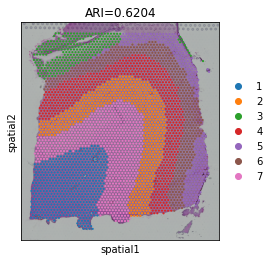

In [12]:
# plotting spatial clustering result
sc.pl.spatial(adata, img_key="hires", color=["domain"], title=['ARI=%.4f'%ARI], show=True)